In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import dijet
import random
from IPython.display import display, Math
from tqdm import tqdm

# setup plotting
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["axes.labelsize"] = 16  
plt.rcParams["xtick.labelsize"] = 14  
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 18  
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.xmargin'] = 0

In [17]:
# calculate bands for correlations

modes = ['t_integrated', 't_differential']
data = {}
data['t_integrated'] = np.load('data/dsa_pT_rs50_Q00p5_xi0p5_pn_200reps.npy', allow_pickle=True).item()
data['t_differential'] = np.load('data/dsa_pT_t0p1_rs50_Q00p5_xi0p5_pn_200reps.npy', allow_pickle=True).item()

confid = 68
bands = {}
for mode in modes:
    bands[mode] = {}
    for obj in ['lower', 'upper', 'mean']:
        bands[mode][obj] = {}

    for corr in ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']:
        corr_reps = [rep[corr] for rep in data[mode]['p']]
        bands[mode]['lower'][corr] = np.percentile(corr_reps, 0.5*(100-confid), axis=0)
        bands[mode]['upper'][corr] = np.percentile(corr_reps, 100 - 0.5*(100-confid), axis=0)
        bands[mode]['mean'][corr] = np.mean(corr_reps, axis=0)

lumi = 100
error = {}
for mode in modes:
    error[mode] = {}
    error[mode]['all'] = np.sqrt(1/(2*lumi*np.array(data[mode]['p'][0]['denom'])))
    error[mode]['tt'] = np.sqrt(2/(2*lumi*np.array(data[mode]['p'][0]['denom'])))

pT_values = data[modes[0]]['pT values']
roots = data[modes[0]]['roots']
space = data[modes[0]]['space']

space_labels = {
    'y' : r'y',
    'z' : r'z',
    'Q2': r'Q^2',
    't' : r't',
    'phi_Dp': r'\phi_{\Delta p}',
    'phi_kp': r'\phi_{k p}'
}

var_labels = [r'p_{\perp}']
for key in space:
    if key == 't': continue
    if isinstance(space[key], list): continue
    var_labels.append(space_labels[key])

num_label = '{}' if len(var_labels)==1 else fr'{len(var_labels)}'
den_label = ''.join(['d' + v for v in var_labels])

info_text = fr'$\sqrt{{s}} = {roots}\,\, \mathrm{{GeV}}$' + '\n'

for var in space:
    if isinstance(space[var], list): 
        low = space[var][0]
        high = space[var][1]
        if var == 'Q2':
            # info_text += fr'$Q^2 \, \in \,[{round(low,1)}, \, {round(high,1)}]\, \mathrm{{GeV^2}}$'
            info_text += fr'$\overline{{Q}}_0 \, = \,0.5\, \mathrm{{GeV}}$'
        elif var == 'y':
            info_text += fr'$y \, \in \, [{round(low,3)}, \, {round(high,3)}]$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, \in \, [{round(low,2)}, \, {round(high,2)}]$' + '\n'
        # elif var == 't':
        #     info_text += fr'$t \, \in \,  [{round(low,2)}, \, {round(high,2)}]\, \mathrm{{GeV}}^2$'
    else:
        value = space[var]
        if var == 'Q2':
            info_text += fr'$Q^2 \, = \,{value}\, \mathrm{{GeV^2}}$' + '\n'
        elif var == 'y':
            info_text += fr'$y \, = \, {value}$' + '\n'
        elif var == 'z':
            info_text += fr'$z \, = \, {value}$' + '\n'
        elif var == 't':
            info_text += fr'$t \, = \,  {value}\, \mathrm{{GeV}}^2$'


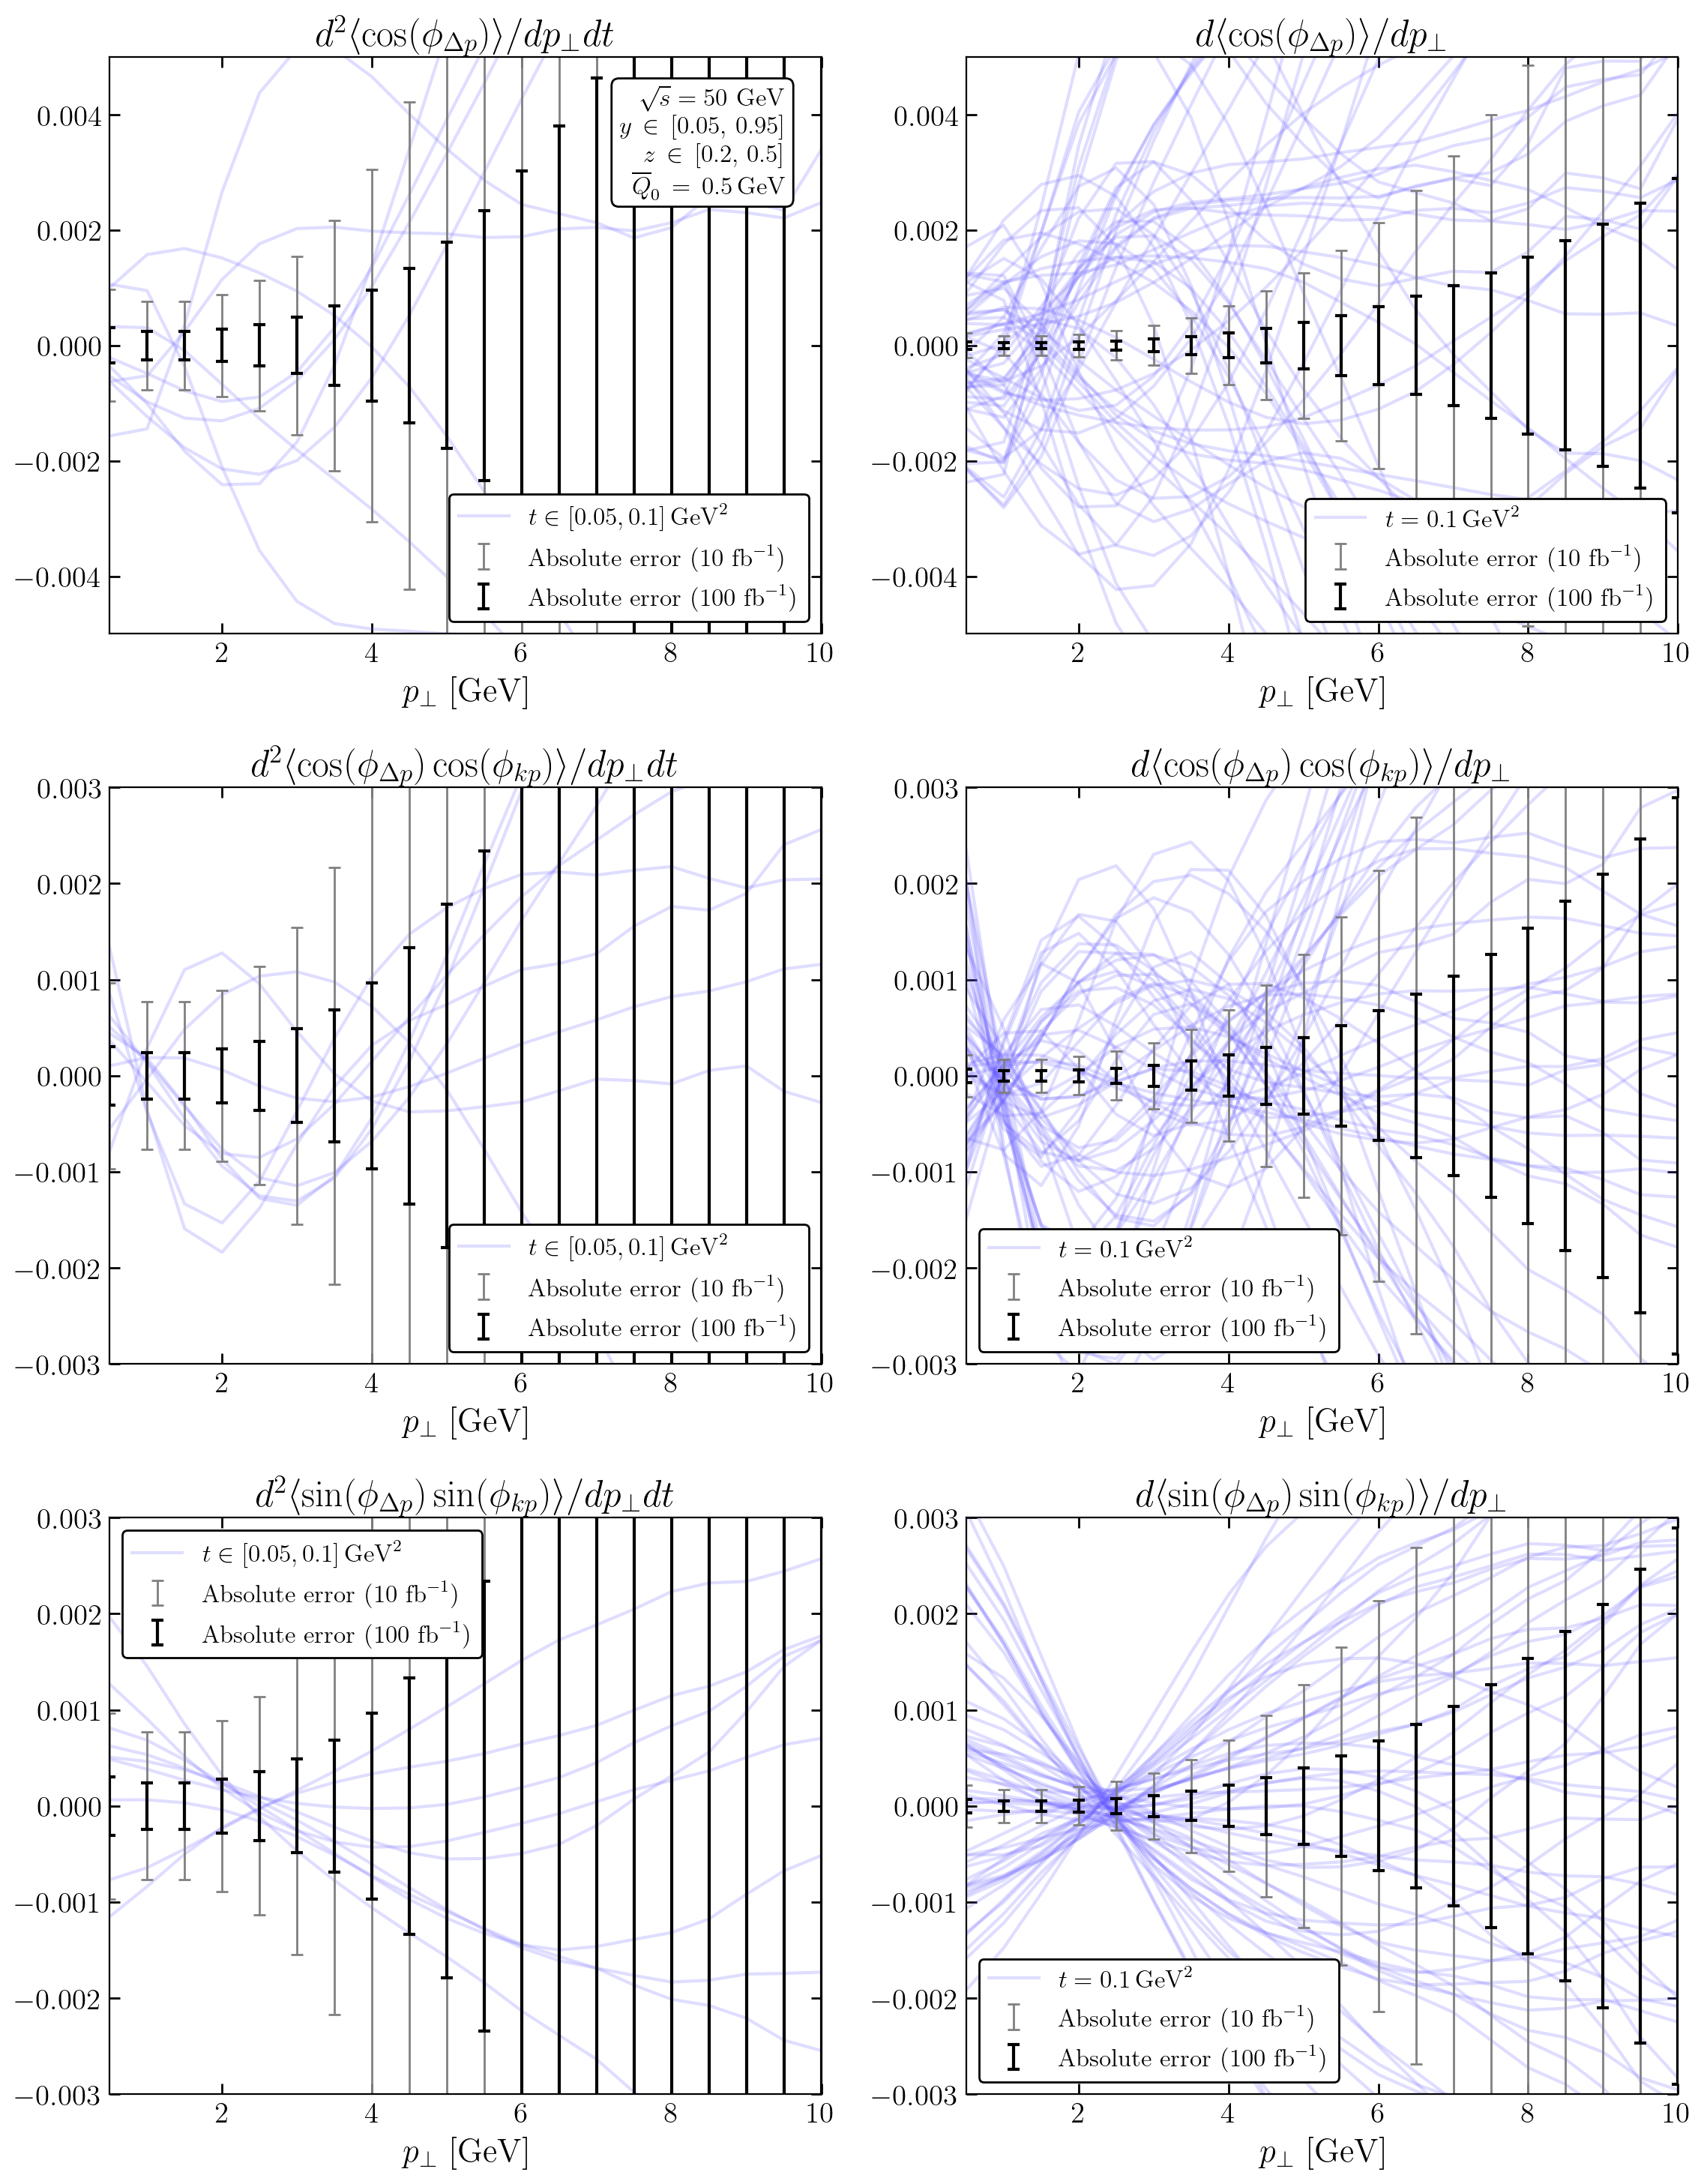

In [27]:
# plot azimuthal correlations
asp_ratio = 3.5/3
psize = 5

nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(asp_ratio*psize*ncols, psize*nrows))
axs = [ax[irow, icol] for irow in range(nrows) for icol in range(ncols)]

save_plots = False
plot_bands = False
alt_defs = False
plot_stat_errors = True

# colors = ['blue']
colors = ['#6257ff']
labels = [r'$t \in [0.05, 0.1] \, \mathrm{GeV}^2$', r'$t=0.1 \, \mathrm{GeV}^2$']

corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp)cos(phi_kp)>', '<sin(phi_Dp)sin(phi_kp)>']
if alt_defs: 
    corrs = ['<1>', '<cos(phi_Dp)>', '<cos(phi_Dp + phi_kp)>', '<cos(phi_Dp - phi_kp)>']

for imode, mode in enumerate(modes):
    for icorr, corr in enumerate(corrs):
        if icorr == 0: continue

        if plot_bands:
            ax[icorr-1, imode].fill_between(pT_values, bands[mode]['lower'][corr], bands[mode]['upper'][corr], color=colors[0], alpha=0.5, label=labels[imode])
        
        else:
            for irep, rep in enumerate(data[mode]['p']):
                if irep == 0:
                    ax[icorr-1, imode].plot(pT_values, np.array(rep[corr]), alpha=0.2, color=colors[0], label=labels[imode])
                else: 
                    ax[icorr-1, imode].plot(pT_values, np.array(rep[corr]), alpha=0.2, color=colors[0])

        if plot_stat_errors:

            if corr == '<1>': emode = 'all'
            else: emode = 'tt'

            ax[icorr-1, imode].errorbar(
                    pT_values, np.zeros(error[mode][emode].shape), yerr=np.sqrt(10)*error[mode][emode], fmt='o',
                    capsize=3, elinewidth=1, capthick=1, color='gray', markersize=0, 
                    label=rf'Absolute error ({round(lumi/10)} $\mathrm{{fb}}^{{-1}}$)'
            )
            ax[icorr-1, imode].errorbar(
                    pT_values, np.zeros(error[mode][emode].shape), yerr=error[mode][emode], fmt='o',
                    capsize=3, elinewidth=1.5, capthick=1.5, color='black', markersize=0, 
                    label=rf'Absolute error ({lumi} $\mathrm{{fb}}^{{-1}}$)'
            )


axs[0].set_xlabel(r'$p_\perp$ [GeV]')
axs[0].set_title(fr'$ d^2 \langle \cos(\phi_{{\Delta p}}) \rangle / d p_\perp dt $')
axs[0].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[0].legend(frameon=True, framealpha=1.0, fancybox=True, edgecolor='black')
axs[0].text(
    0.95, 0.95, info_text, 
    transform=axs[0].transAxes,
    ha='right', va='top', 
    fontsize=12, wrap=True, 
    bbox=dict(boxstyle='round', facecolor='white', alpha=1.0, edgecolor='black')
)
axs[0].set_ylim([-0.005, 0.005])
# axs[1].semilogy()


axs[1].set_xlabel(r'$p_\perp$ [GeV]')
axs[1].set_title(fr'$ d \langle \cos(\phi_{{\Delta p}}) \rangle / d p_\perp $')
axs[1].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[1].legend(frameon=True, framealpha=1.0, fancybox=True, edgecolor='black')
axs[1].set_ylim([-0.005, 0.005])
# axs[1].semilogy()


axs[2].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[2].set_title(fr'$ d^2  \langle \cos(\phi_{{\Delta p}}) \cos(\phi_{{k p}}) \rangle / dp_\perp dt $')
axs[2].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[2].legend(frameon=True, framealpha=1.0, fancybox=True, edgecolor='black')
axs[2].set_ylim([-0.003, 0.003])


axs[3].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[3].set_title(fr'$ d   \langle \cos(\phi_{{\Delta p}}) \cos(\phi_{{k p}}) \rangle / d p_\perp $')
axs[3].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[3].legend(frameon=True, framealpha=1.0, fancybox=True, edgecolor='black')
axs[3].set_ylim([-0.003, 0.003])


axs[4].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[4].set_title(fr'$ d^2 \langle \sin(\phi_{{\Delta p}}) \sin(\phi_{{k p}})  \rangle /  dp_\perp dt $')
axs[4].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[4].legend(frameon=True, framealpha=1.0, fancybox=True, edgecolor='black')
axs[4].set_ylim([-0.003, 0.003])

axs[5].set_xlabel(r'$p_{\perp}$ [GeV]')
axs[5].set_title(fr'$ d \langle \sin(\phi_{{\Delta p}}) \sin(\phi_{{k p}})  \rangle /  dp_\perp $')
axs[5].tick_params(axis="both", direction="in", length=5, width=1, which='both', right=True, top=True)
axs[5].legend(frameon=True, framealpha=1.0, fancybox=True, edgecolor='black')
axs[5].set_ylim([-0.003, 0.003])

plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

if save_plots:
    if plot_bands:
        fig.savefig('plots/dsa_band_oam3_range10_t_integration.pdf', dpi=400, bbox_inches="tight")
    else:
        fig.savefig('plots/dsa_lines_oam3_range10_t_integration.pdf', dpi=400, bbox_inches="tight")
